## **Generate CSV of IPS duration from CME with CME speed**

Necessary imports

In [3]:
from datetime import datetime
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt

Choose start date and end date to fetch the data

In [4]:
start_date = "2009-01-01"
end_date   = "2025-09-1"

APIs for fetching Coronal Mass Ejection and Interplanatory Shock data

In [5]:
cme_url = f"https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CME?startDate={start_date}&endDate={end_date}"
cme_data = requests.get(cme_url).json()
ips_url = f"https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/IPS?startDate={start_date}&endDate={end_date}"
ips_data = requests.get(ips_url).json()

Build a dataset linking CME events with their associated IPS events.

*   Step 1: Create a lookup table of CME events (by activityID) with start time and most accurate speed.
*   Step 2: For each IPS event, find its linked CME, compute the time difference (in hours) between the CME start and IPS observation, and store these records. Finally, convert the collected records into a DataFrame.




In [6]:
# Step 1: Create a CME lookup table by activityID
cme_lookup = {}
for cme in cme_data:
    cme_id = cme["activityID"]
    cme_speed = None
    # get the most accurate analysis
    for analysis in cme.get("cmeAnalyses", []):
        if analysis.get("isMostAccurate"):
            cme_speed = analysis.get("speed")
    cme_lookup[cme_id] = {
        "startTime": cme["startTime"],
        "speed": cme_speed
    }

# Step 2: Create IPS dataframe with linked CME info
rows = []
for ips in ips_data:
    ips_time = datetime.strptime(ips["eventTime"], "%Y-%m-%dT%H:%MZ")
    linked_events = ips.get("linkedEvents")
    if linked_events:
        for link in linked_events:
            cme_id = link["activityID"]
            if cme_id in cme_lookup:
                cme_time = datetime.strptime(cme_lookup[cme_id]["startTime"], "%Y-%m-%dT%H:%MZ")
                time_diff_hours = (ips_time - cme_time).total_seconds() / 3600  # in hours
                rows.append({
                    "CME_ID": cme_id,
                    "IPS_ID": ips["activityID"],
                    "CME_speed": cme_lookup[cme_id]["speed"],
                    "Time_diff_hours": time_diff_hours
                })

df = pd.DataFrame(rows)

Find correlation

In [7]:
correlation = df["CME_speed"].corr(df["Time_diff_hours"])
print("Correlation between CME speed and IPS arrival time difference:", correlation)

Correlation between CME speed and IPS arrival time difference: -0.49935258700153506


Save the linked IPS events with their CME start time and speed to CSV

In [8]:
df.to_csv("cme_ips_data.csv", index=False)
print("Data saved to cme_ips_data.csv")

Data saved to cme_ips_data.csv


Plot the CME speed vs Time difference

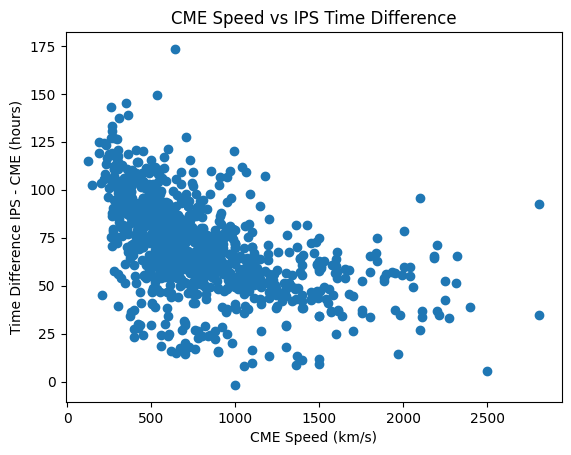

In [9]:
plt.scatter(df["CME_speed"], df["Time_diff_hours"])
plt.xlabel("CME Speed (km/s)")
plt.ylabel("Time Difference IPS - CME (hours)")
plt.title("CME Speed vs IPS Time Difference")
plt.show()